In [1]:
# For passwords & database access:
import psycopg2
import psycopg2.extras
import getpass

# For plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets

# For math
import numpy as np
import pandas as pd
from decam_utils import *
from scipy.optimize import curve_fit
from scipy.stats import linregress

import time

This notebook searches the extragalactic fields for candidates that (on their first night of detection) rose by at least 0.2 mag over at least 4 detections

In [2]:
# Logging in
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


#### The filter parameters

In [3]:
errmult = .25 # the fraction of an error bar we want to give as leeway (1 is a full error bar on both data points, 0 is no tolerance).

numdet = 5 # Minimum number of detections on the first night of data for the filter to consider a candidate

magamp = 0.2 # Minimum magnitude change throughout the candidates first night of detection

#### The filter

In [4]:
# Get a list of every MJD for which we have an image
query = ("SELECT e.mjd FROM exposures e "
         "WHERE e.proposalid = '2021A-0113' "
         "OR e.proposalid = '2021B-0149' "
         "LIMIT 10000000")
cursor.execute( query, )

datesquery = np.array(cursor.fetchall())

In [5]:
# Make a list of every observing night (by rounding to the nearest MJD)
odatesrd = np.unique( np.round( datesquery ) )
datemsks = [np.where(np.abs(datesquery-i) < 0.5) for i in odatesrd]
odates = np.array([np.mean(datesquery[i]) for i in datemsks])

In [6]:
def lin(x,m,b):
    return m*x + b

In [7]:
fr = []
frdates = []
filidx = []
fitpararr = []
amps = []
maxmags = []

t1 = time.time() # should be about 30 seconds

goodfnms = good_fnms(cursor)[0] # Pulls all the exposure IDs of science images 

for field in ["COSMOS", "ELIAS"]:
    for fil in ["g","r","i"]:
        tempfr = [] # List for the names of fast-rising candidates
        tempfrdates = [] # List for the dates on which fast riser behavior was observed
        
        oldcands = np.array( [] ) # used to check if candidates have been detected before

        for i in range(len(odatesrd)):
            # Loop through each observing night
            # Grab all detections within a day of the night in question
            lodate = odatesrd[i] - 0.5
            hidate = odatesrd[i] + 0.5
            if field == "COSMOS":
                query = ("SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id, o.magerr FROM objects o "
                         "JOIN subtractions s ON s.id=o.subtraction_id "
                         "JOIN exposures e on s.exposure_id = e.id "
                         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
                         "WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) "
                         "AND rbs.rb > 0.4 "
                         "AND e.mjd > %s "
                         "AND e.mjd < %s "
                         "AND e.filter = %s "
                         "AND (e.proposalid = '2021A-0113' "
                         "OR e.proposalid = '2021B-0149') "
                         "LIMIT 10000000")
            elif field == "ELIAS":
                query = ("SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id, o.magerr FROM objects o "
                         "JOIN subtractions s ON s.id=o.subtraction_id "
                         "JOIN exposures e on s.exposure_id = e.id "
                         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
                         "WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) "
                         "AND rbs.rb > 0.4 "
                         "AND e.mjd > %s "
                         "AND e.mjd < %s "
                         "AND e.filter = %s "
                         "AND (e.proposalid = '2021A-0113' "
                         "OR e.proposalid = '2021B-0149') "
                         "LIMIT 10000000")
            cursor.execute( query, ( lodate, hidate, fil, ) )

            # Store that nights detections in an array
            tempres = np.array( cursor.fetchall(), dtype=str ).transpose()

            if len( tempres ) > 0: # Takes care of errors from gaps in the observations by skipping empty nights
                # print(field, fil, i)
                # Cut out duplicate objects
                dupearr = np.array( [tempres[0], tempres[2], tempres[3], tempres[4], tempres[5], tempres[6]] ).transpose()
                dupearr = [ " ".join(j) for j in dupearr ]
                dupearr, ind = np.unique( dupearr, return_index=True )

                # Rejoin the array without the duplicates
                uarr = np.array( [ i.split(" ") for i in dupearr ] ).transpose()
                res = np.array( [uarr[0], tempres[1][ind], uarr[1], uarr[2], uarr[3], uarr[4], uarr[5]] )
                
                # Cut out non-science images
                msk = np.isin(res[5], goodfnms)
                res = np.array([i[msk] for i in res])
                
                # Create an array of each unique candidate detected that night
                ucands, uind, ucounts = np.unique( res[0], return_counts=True, return_index=True )
                
                # Isolate those with at least numdet detections
                goodcands = ucands[ ucounts >= numdet ]


                # Make an array of detections for each of those candidates, store all of those arrays in "arr"
                arr = np.ones( len( goodcands ), dtype=object )
                for j in range( len( goodcands ) ):
                    arr[j] = res[:,res[0,:] == goodcands[j]]
                # Mask out those that 
                # A) have been detected in previous nights,
                # B) don"t change by at least 0.2 mag
                # C) don"t rise in every subsequent detection, or 
                
                good = np.ones( len( arr ), dtype=bool )
                for j in range( len( arr ) ):
                    # A)
                    # if arr[j][0][0] in oldcands:
                    #     good[j] = False
                    
                    # B)
                    amp = np.max( arr[j][3].astype(float) ) - np.min( arr[j][3].astype(float) )
                    if amp < magamp:
                        good[j] = False
                    else:
                        ntmjds  = arr[j][2].astype(float)
                        ntmags  = arr[j][3].astype(float)
                        ntmgerr = arr[j][6].astype(float)
                        maxmag = np.min(ntmags)
                        
                        fitpars = linregress(ntmjds, ntmags)
                        slope, intercept, pearson = fitpars[0], fitpars[1], fitpars[2]
                        
                        if (pearson > -0.5) | (np.isnan(pearson)):
                            good[j] = False
                        else:
                            fitpararr.append([slope,intercept])
                            amps.append(amp)
                            maxmags.append(maxmag)
                        # for k in range( len( arr[j][3] ) - 1 ):
                            # C)
                            # if float(arr[j][3][k]) + errmult * float(arr[j][6][k]) < float(arr[j][3][k + 1]) - errmult * float(arr[j][6][k+1]):
                            #     good[j] = False
                    
                # Apply those cuts and append the candidates that passed to fr and frdates
                for j in range( len( arr[good] ) ):
                    tempfr.append( arr[good][j][0][0] )
                    tempfrdates.append( [lodate, hidate] )
            
            # Make a note of all candidates detected this night (for cutting out things that have been previously detected)
            try:
                oldcands = np.append( oldcands, ucands )
            except NameError:
                pass
            fr.append(tempfr)
            frdates.append(tempfrdates)
        filidx.append([len(j) for j in fr][-1])
        
x = []
y = []
ind = np.unique(fr, return_index=True)[1]
for i in [fr[ind] for ind in sorted(ind)]:
    x.extend(i)
for i in [frdates[ind] for ind in sorted(ind)]:
    y.extend(i)
fr = x
frdates = y

fitpararr = np.array(fitpararr)
amps = np.array(amps)
maxmags = np.array(maxmags)

t2 = time.time()
print(t2-t1)

del x, y, ind

27.773372411727905


/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
len(fr)

(535, 535, 535)

#### Determine if the filter was passed on a candidates first or only night in a filter

In [9]:
# maxmag = np.ones( len( fr ), dtype=object )
fn = np.ones( len( fr ), dtype=object )
on = np.ones( len( fr ), dtype=object )
for i in range(len(fr)):
    # maxmag[i] = []
    fn[i] = []
    on[i] = []
    for fil in ["g","r","i"]:
        query = ("SELECT o.mag, e.mjd FROM objects o "
                 "JOIN subtractions s ON s.id=o.subtraction_id "
                 "JOIN exposures e on s.exposure_id = e.id "
                 "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
                 "WHERE rbs.rb > 0.4 "
                 "AND e.filter = %s "
                 "AND (e.proposalid = '2021A-0113' "
                 "OR e.proposalid = '2021B-0149') "
                 "AND o.candidate_id = %s "
                 "ORDER BY e.mjd "
                 "LIMIT 10000000")
        cursor.execute( query, ( fil, fr[i], ) )
        tempres = np.array( cursor.fetchall(), dtype=float ).transpose()
        if len(tempres) == 0:
            # maxmag[i].append(0)
            fn[i].append(False)
            on[i].append(False)
        else:
            # maxmag[i].append(np.min(tempres[0]))
            lastnight = float(tempres[1][-1])
            firstnight = float(tempres[1][0])
            if firstnight < frdates[i][0]:
                fn[i].append(False)
                on[i].append(False)
            else:
                fn[i].append(True)
                if lastnight > frdates[i][1]:
                    on[i].append(False)
                else:
                    on[i].append(True)


#### Combine all that info into a dataframe

In [10]:
df = pd.DataFrame(index = range(len(fr)), columns = ["CandID", "Field", "Filter", "Night", "DelMag", "PeakMag", "FirstNight", "OnlyNight", "Slope", "Intercept"])

for i in range(len(fr)):
    df["CandID"][i] = fr[i]
    if i < sum(filidx[:3]):
        df["Field"][i] = "COSMOS"
    else: 
        df["Field"][i] = "ELAIS"
    df["Night"][i] = frdates[i][0]+0.5
    df["Slope"][i] = fitpararr[i][0]
    df["Intercept"][i] = fitpararr[i][1]
    df["DelMag"][i] = amps[i]
    df["PeakMag"][i] = maxmags[i]
    if i < filidx[0]:
        df["Filter"][i] = "g"
        df["FirstNight"][i] = fn[i][0]
        df["OnlyNight"][i] = on[i][0]
    elif (i >= filidx[0]) & (i < sum(filidx[:2])):
        df["Filter"][i] = "r"
        df["FirstNight"][i] = fn[i][1]
        df["OnlyNight"][i] = on[i][1]
    elif (i >= sum(filidx[:2])) & (i < sum(filidx[:3])):
        df["Filter"][i] = "i"
        df["FirstNight"][i] = fn[i][2]
        df["OnlyNight"][i] = on[i][2]
    elif (i >= sum(filidx[:3])) & (i < sum(filidx[:4])):
        df["Filter"][i] = "g"
        df["FirstNight"][i] = fn[i][0]
        df["OnlyNight"][i] = on[i][0]
    elif (i >= sum(filidx[:4])) & (i < sum(filidx[:5])):
        df["Filter"][i] = "r"
        df["FirstNight"][i] = fn[i][1]
        df["OnlyNight"][i] = on[i][1]
    elif (i >= sum(filidx[:5])): #& (i < sum(filidx[:6])):
        df["Filter"][i] = "i"
        df["FirstNight"][i] = fn[i][2]
        df["OnlyNight"][i] = on[i][2]
        
### This takes care of duplicates that arise from having observations closer together than usual
df = df.drop_duplicates(subset=["CandID", "Field", "Filter", "DelMag", "PeakMag"])
try:
    df = df.reset_index(drop=True)
except ValueError:
    pass
fr = df["CandID"]
frdates = [[df["Night"][i]-0.5,df["Night"][i]+0.5] for i in range(len(fr))]

In [25]:
### Summary of Results:
print("There were %s total fast risers" % len(df))
print("Spread over %s candidates" % len(np.unique(df["CandID"])))
print("%s in g, %s in r, and %s in i" % (len(df[df["Filter"]=="g"]), len(df[df["Filter"]=="r"]), len(df[df["Filter"]=="i"])))
print("%s in COSMOS, %s in ELAIS" % (len(df[df["Field"]=="COSMOS"]), len(df[df["Field"]=="ELAIS"])))
print("%s of these rose quickly on their first night" % len(df[df["FirstNight"]==True]))
print("%s of those were only detected on one night" % len(df[df["OnlyNight"]==True]))

There were 535 total fast risers
Spread over 379 candidates
238 in g, 200 in r, and 97 in i
361 in COSMOS, 174 in ELAIS
27 of these rose quickly on their first night
6 of those were only detected on one night


#### How much did the fast risers rise in a night?

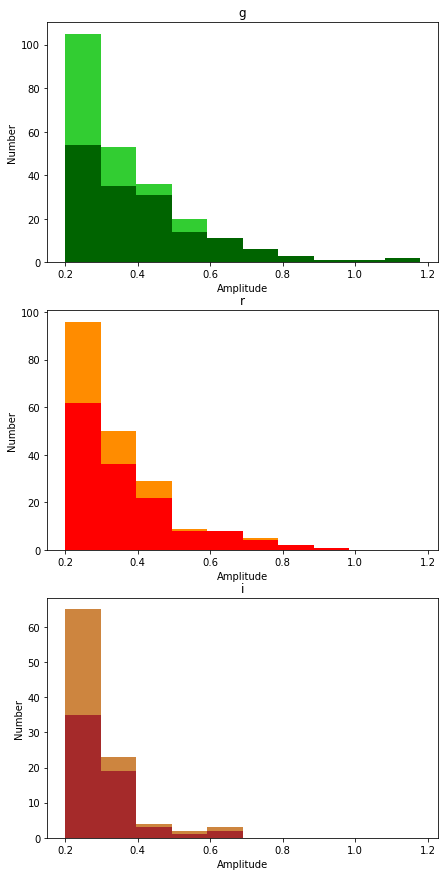

In [13]:
fig, ax = plt.subplots(3, sharex=True, figsize=[7,15])
bins = ax[0].hist(
    [df["DelMag"].where((df["Filter"]=="g") & (df["Field"]=="COSMOS")).dropna(),
    df["DelMag"].where((df["Filter"]=="g") & (df["Field"]=="ELAIS")).dropna()],
    color=["darkgreen","limegreen"], 
    stacked=True)[1]
ax[0].set_xlabel("Amplitude")
ax[0].set_ylabel("Number")
ax[0].set_title("g")
ax[0].tick_params(labelbottom=True)

ax[1].hist(
    [df["DelMag"].where((df["Filter"]=="r") & (df["Field"]=="COSMOS")).dropna(),
    df["DelMag"].where((df["Filter"]=="r") & (df["Field"]=="ELAIS")).dropna()],
    color=["red","darkorange"],
    bins=bins,
    stacked=True)
ax[1].set_xlabel("Amplitude")
ax[1].set_ylabel("Number")
ax[1].set_title("r")
ax[1].tick_params(labelbottom=True)

ax[2].hist(
    [df["DelMag"].where((df["Filter"]=="i") & (df["Field"]=="COSMOS")).dropna(),
    df["DelMag"].where((df["Filter"]=="i") & (df["Field"]=="ELAIS")).dropna()],
    color=["brown","peru"],
    bins=bins,
    stacked=True)
ax[2].set_xlabel("Amplitude")
ax[2].set_ylabel("Number")
ax[2].set_title("i");

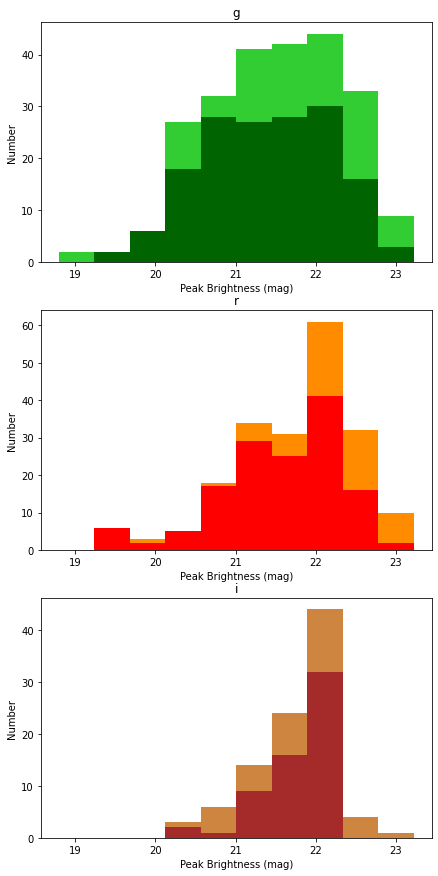

In [14]:
fig, ax = plt.subplots(3, sharex=True, figsize=[7,15])
bins = ax[0].hist(
    [df["PeakMag"].where((df["Filter"]=="g") & (df["Field"]=="COSMOS")).dropna(),
    df["PeakMag"].where((df["Filter"]=="g") & (df["Field"]=="ELAIS")).dropna()],
    color=["darkgreen","limegreen"], 
    stacked=True)[1]
ax[0].set_xlabel("Peak Brightness (mag)")
ax[0].set_ylabel("Number")
ax[0].set_title("g")
ax[0].tick_params(labelbottom=True)

ax[1].hist(
    [df["PeakMag"].where((df["Filter"]=="r") & (df["Field"]=="COSMOS")).dropna(),
    df["PeakMag"].where((df["Filter"]=="r") & (df["Field"]=="ELAIS")).dropna()],
    color=["red","darkorange"],
    bins=bins,
    stacked=True)
ax[1].set_xlabel("Peak Brightness (mag)")
ax[1].set_ylabel("Number")
ax[1].set_title("r")
ax[1].tick_params(labelbottom=True)

ax[2].hist(
    [df["PeakMag"].where((df["Filter"]=="i") & (df["Field"]=="COSMOS")).dropna(),
    df["PeakMag"].where((df["Filter"]=="i") & (df["Field"]=="ELAIS")).dropna()],
    color=["brown","peru"],
    bins=bins,
    stacked=True)
ax[2].set_xlabel("Peak Brightness (mag)")
ax[2].set_ylabel("Number")
ax[2].set_title("i");

#### Plotting lightcurves/cutouts next to dataframe printout

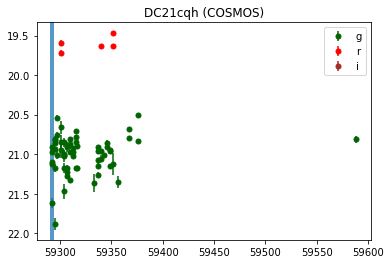

CandID              DC21cqh
Field                COSMOS
Filter                    g
Night               59292.0
DelMag             0.699107
PeakMag           20.912973
FirstNight             True
OnlyNight             False
Slope              -3.34893
Intercept     198586.133227
Name: 0, dtype: object


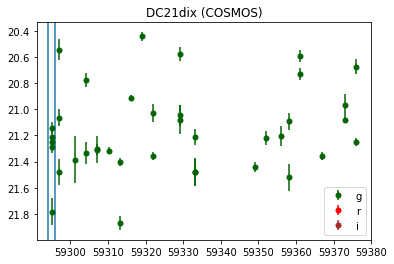

CandID              DC21dix
Field                COSMOS
Filter                    g
Night               59295.0
DelMag             0.642254
PeakMag           21.140289
FirstNight             True
OnlyNight             False
Slope             -4.023776
Intercept     238611.498334
Name: 5, dtype: object


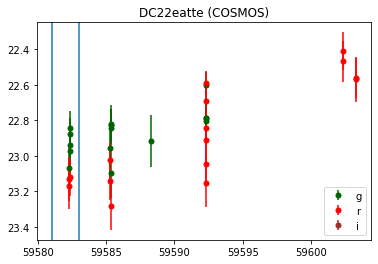

CandID            DC22eatte
Field                COSMOS
Filter                    g
Night               59582.0
DelMag             0.222359
PeakMag           22.844479
FirstNight             True
OnlyNight             False
Slope             -5.868526
Intercept     349683.279102
Name: 153, dtype: object


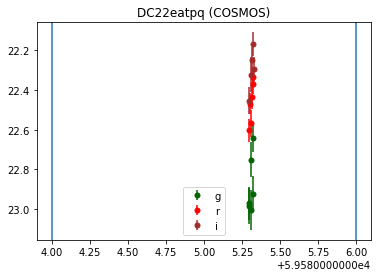

CandID            DC22eatpq
Field                COSMOS
Filter                    g
Night               59585.0
DelMag             0.361371
PeakMag            22.64313
FirstNight             True
OnlyNight              True
Slope             -9.157976
Intercept     545703.735516
Name: 156, dtype: object


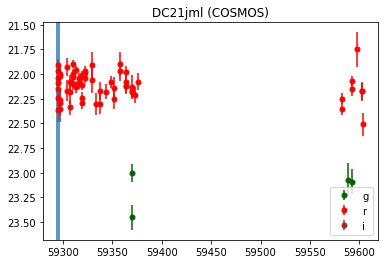

CandID              DC21jml
Field                COSMOS
Filter                    r
Night               59295.0
DelMag             0.459825
PeakMag           21.904273
FirstNight             True
OnlyNight             False
Slope             -3.236668
Intercept     191940.673306
Name: 160, dtype: object


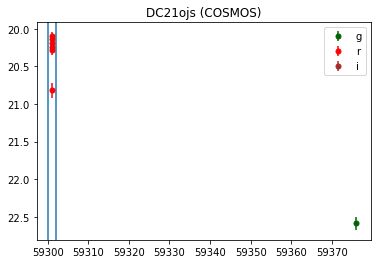

CandID              DC21ojs
Field                COSMOS
Filter                    r
Night               59301.0
DelMag             0.717287
PeakMag           20.100539
FirstNight             True
OnlyNight              True
Slope             -4.281794
Intercept     253935.381199
Name: 187, dtype: object


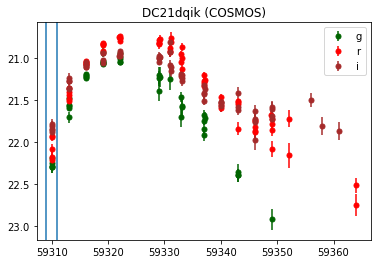

CandID             DC21dqik
Field                COSMOS
Filter                    r
Night               59310.0
DelMag             0.281211
PeakMag           21.930492
FirstNight             True
OnlyNight             False
Slope             -3.011379
Intercept     178627.172266
Name: 197, dtype: object


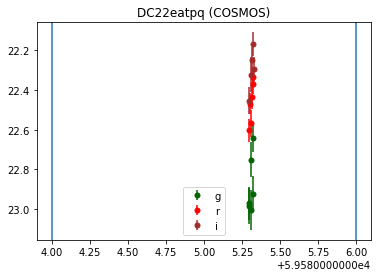

CandID            DC22eatpq
Field                COSMOS
Filter                    r
Night               59585.0
DelMag             0.266987
PeakMag           22.336166
FirstNight             True
OnlyNight              True
Slope             -7.661601
Intercept     456541.330024
Name: 297, dtype: object


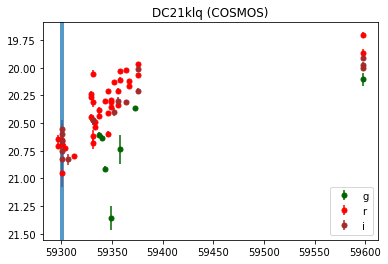

CandID              DC21klq
Field                COSMOS
Filter                    i
Night               59301.0
DelMag             0.266862
PeakMag            20.55709
FirstNight             True
OnlyNight             False
Slope             -14.32534
Intercept     849528.754723
Name: 314, dtype: object


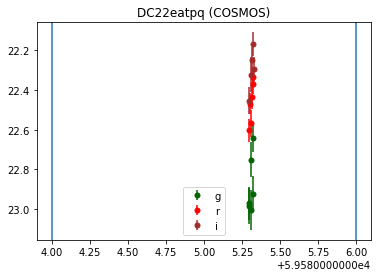

CandID            DC22eatpq
Field                COSMOS
Filter                    i
Night               59585.0
DelMag             0.284804
PeakMag           22.168113
FirstNight             True
OnlyNight              True
Slope             -7.236664
Intercept     431221.221005
Name: 358, dtype: object


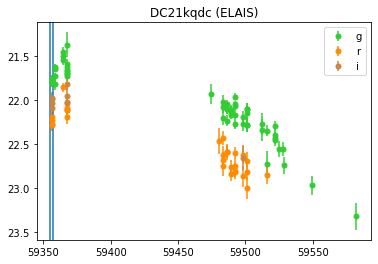

CandID             DC21kqdc
Field                 ELAIS
Filter                    g
Night               59356.0
DelMag              0.22674
PeakMag           21.761014
FirstNight             True
OnlyNight             False
Slope             -2.630984
Intercept     156187.520115
Name: 361, dtype: object


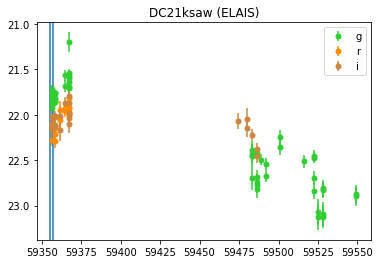

CandID             DC21ksaw
Field                 ELAIS
Filter                    g
Night               59356.0
DelMag             0.211503
PeakMag            21.71273
FirstNight             True
OnlyNight             False
Slope             -2.080626
Intercept     123520.284009
Name: 362, dtype: object


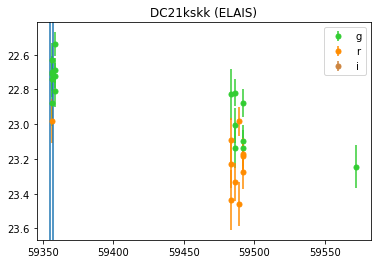

CandID             DC21kskk
Field                 ELAIS
Filter                    g
Night               59356.0
DelMag             0.248839
PeakMag           22.628101
FirstNight             True
OnlyNight             False
Slope             -4.015424
Intercept     238363.802053
Name: 363, dtype: object


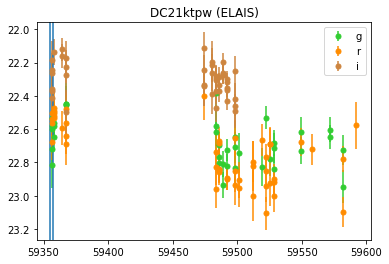

CandID             DC21ktpw
Field                 ELAIS
Filter                    g
Night               59356.0
DelMag             0.281968
PeakMag           22.531409
FirstNight             True
OnlyNight             False
Slope             -4.368764
Intercept     259336.733107
Name: 364, dtype: object


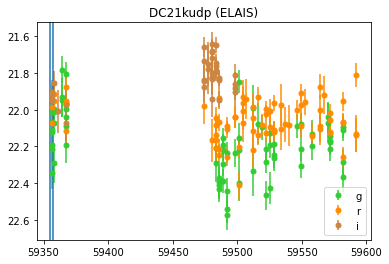

CandID             DC21kudp
Field                 ELAIS
Filter                    g
Night               59356.0
DelMag             0.332322
PeakMag           22.013603
FirstNight             True
OnlyNight             False
Slope             -5.379289
Intercept     319317.325597
Name: 365, dtype: object


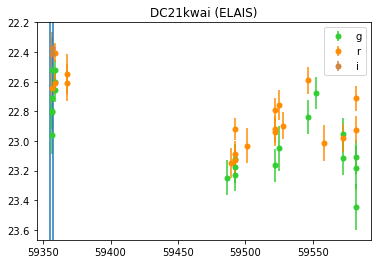

CandID             DC21kwai
Field                 ELAIS
Filter                    g
Night               59356.0
DelMag             0.440969
PeakMag           22.518462
FirstNight             True
OnlyNight             False
Slope             -5.820994
Intercept     345535.963266
Name: 366, dtype: object


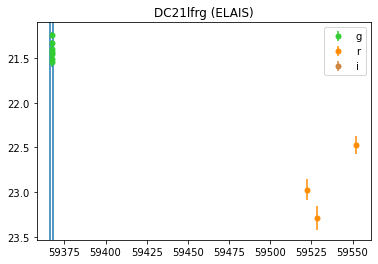

CandID             DC21lfrg
Field                 ELAIS
Filter                    g
Night               59367.0
DelMag             0.303401
PeakMag           21.243289
FirstNight             True
OnlyNight              True
Slope             -3.599569
Intercept     213718.412127
Name: 390, dtype: object


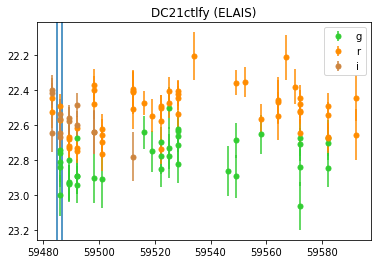

CandID            DC21ctlfy
Field                 ELAIS
Filter                    g
Night               59486.0
DelMag              0.25761
PeakMag           22.743398
FirstNight             True
OnlyNight             False
Slope             -4.707101
Intercept     280030.469234
Name: 406, dtype: object


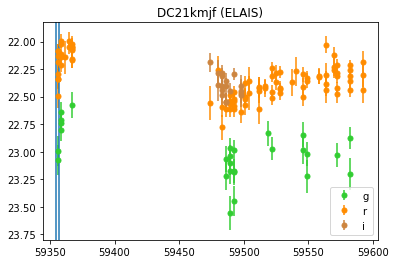

CandID             DC21kmjf
Field                 ELAIS
Filter                    r
Night               59356.0
DelMag             0.411834
PeakMag           22.083743
FirstNight             True
OnlyNight             False
Slope             -4.466129
Intercept     265115.528078
Name: 441, dtype: object


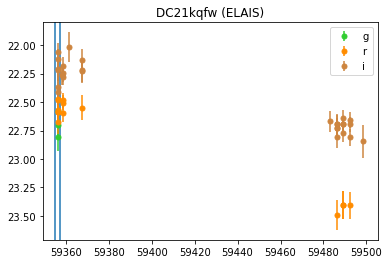

CandID             DC21kqfw
Field                 ELAIS
Filter                    r
Night               59356.0
DelMag             0.200354
PeakMag           22.472238
FirstNight             True
OnlyNight             False
Slope             -3.134944
Intercept     186101.477557
Name: 442, dtype: object


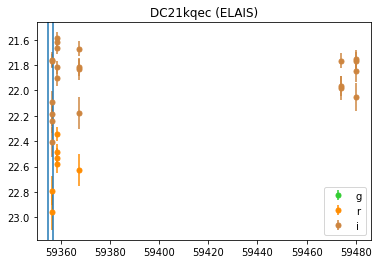

CandID             DC21kqec
Field                 ELAIS
Filter                    i
Night               59356.0
DelMag             0.646813
PeakMag           21.757789
FirstNight             True
OnlyNight             False
Slope            -12.680593
Intercept     752696.240451
Name: 498, dtype: object


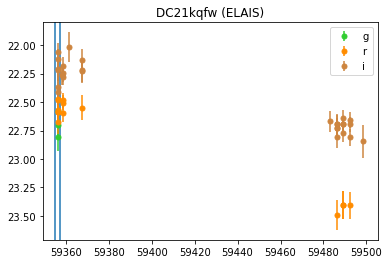

CandID             DC21kqfw
Field                 ELAIS
Filter                    i
Night               59356.0
DelMag              0.35154
PeakMag           22.057095
FirstNight             True
OnlyNight             False
Slope             -4.661878
Intercept     276734.460635
Name: 499, dtype: object


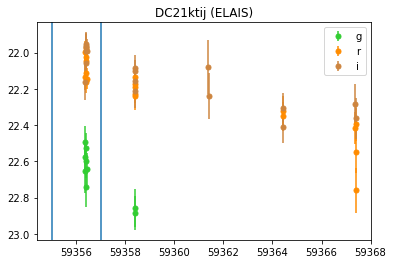

CandID             DC21ktij
Field                 ELAIS
Filter                    i
Night               59356.0
DelMag             0.207903
PeakMag           21.955699
FirstNight             True
OnlyNight             False
Slope             -1.877626
Intercept     111471.118637
Name: 500, dtype: object


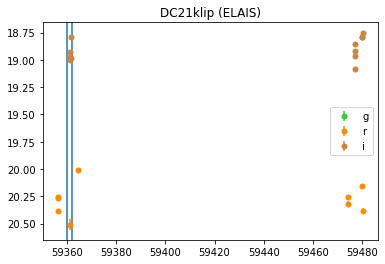

CandID             DC21klip
Field                 ELAIS
Filter                    i
Night               59361.0
DelMag             0.207501
PeakMag           18.790144
FirstNight             True
OnlyNight             False
Slope             -2.711463
Intercept     160975.145814
Name: 502, dtype: object


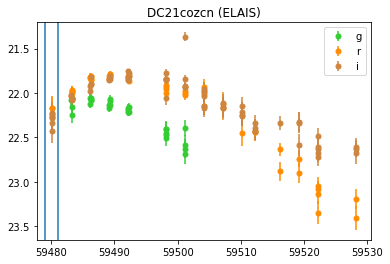

CandID            DC21cozcn
Field                 ELAIS
Filter                    i
Night               59480.0
DelMag              0.20227
PeakMag           22.225264
FirstNight             True
OnlyNight             False
Slope             -2.346306
Intercept     139580.881289
Name: 518, dtype: object


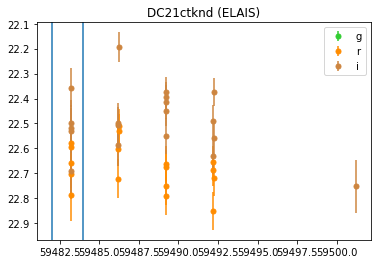

CandID            DC21ctknd
Field                 ELAIS
Filter                    i
Night               59483.0
DelMag             0.332324
PeakMag           22.356446
FirstNight             True
OnlyNight             False
Slope             -7.531406
Intercept     448014.703665
Name: 521, dtype: object


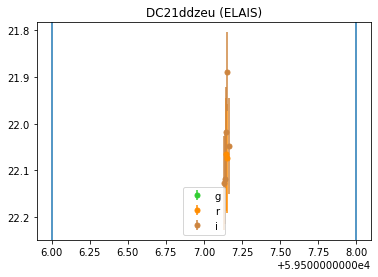

CandID            DC21ddzeu
Field                 ELAIS
Filter                    i
Night               59507.0
DelMag              0.23808
PeakMag           21.888725
FirstNight             True
OnlyNight              True
Slope             -4.619783
Intercept     274932.147435
Name: 531, dtype: object


In [34]:
### Plotting up each of the identified fast risers
### To plot some subset, replace the following line with "for i in df[CONDITION].index:", i.e. "for i in df[df["OnlyNight"]==True].index:"
### would plot only candidates that passed on their only detected night

# for i in range( len( fr ) ):    
for i in df[df["FirstNight"]==True].index:
# for i in df[df["CandID"]=="DC22eatpq"].index:
    ### Plotting the lightcurves
    query = ('SELECT c.id, e.mjd, o.mag, o.magerr, e.filter, o.ra FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE c.id=%s '
             'AND rbs.rb > 0.4')
    cursor.execute( query, ( fr[i], ) )
    
    array = np.array( cursor.fetchall() ).transpose()
    gmsk = array[4] == 'g'
    rmsk = array[4] == 'r'
    imsk = array[4] == 'i'
    
    
    # Color consistency
    if df["Field"][i] == "COSMOS": c = ["darkgreen","red","brown"]
    elif df["Field"][i] == "ELAIS": c = ["limegreen","darkorange","peru"]
    
    
    plt.errorbar( ( array[1][gmsk] ).astype(float), 
                 ( array[2][gmsk] ).astype(float), 
                 yerr=array[3][gmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[0], 
                 label='g' )
    plt.errorbar( ( array[1][rmsk] ).astype(float), 
                 ( array[2][rmsk] ).astype(float), 
                 yerr=array[3][rmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[1], 
                 label='r' )
    plt.errorbar( ( array[1][imsk] ).astype(float), 
                 ( array[2][imsk] ).astype(float), 
                 yerr=array[3][imsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[2], 
                 label='i' )
    
    ### Indicating the interesting part of the light curve
    plt.axvline( float( frdates[i][0] - 0.5 ) )
    plt.axvline( float( frdates[i][1] + 0.5 ) )
    
    # plt.xlim(float(frdates[i][0] - 0.5), float( frdates[i][1] + 0.5))
    
    
    plt.title( array[0][0]+" ("+df["Field"][i]+")")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()
    ### Cutouts
    query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
              'INNER JOIN objects o ON c.object_id=o.id '
              'INNER JOIN candidates cand ON o.candidate_id=cand.id '
              'INNER JOIN subtractions s ON o.subtraction_id=s.id '
              'INNER JOIN exposures e ON s.exposure_id=e.id '
              'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
              'WHERE cand.id=%s '
              'AND rbs.rb > 0.4 '
              'ORDER BY e.mjd '
              'LIMIT 1')
    cursor.execute( query, ( fr[i], ) )
    for row in cursor:
        label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
        newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
        refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
        subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
        box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
        display( box )
    
    ### Details
    print(df.loc()[i])

In [30]:
df[df.duplicated(subset=["Night", "CandID"], keep=False)].sort_values(by=["CandID","Night"]).index
# len(np.unique(df["CandID"][df["FirstNight"]==True]))

Int64Index([ 66, 210,  92, 237,  29, 172, 442, 499, 383, 456, 466, 523,  27,
            168, 203, 324,  86, 228, 156, 297, 358],
           dtype='int64')

In [17]:
clmtmgs, elmtmgs = lmt_mgs(cursor)

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


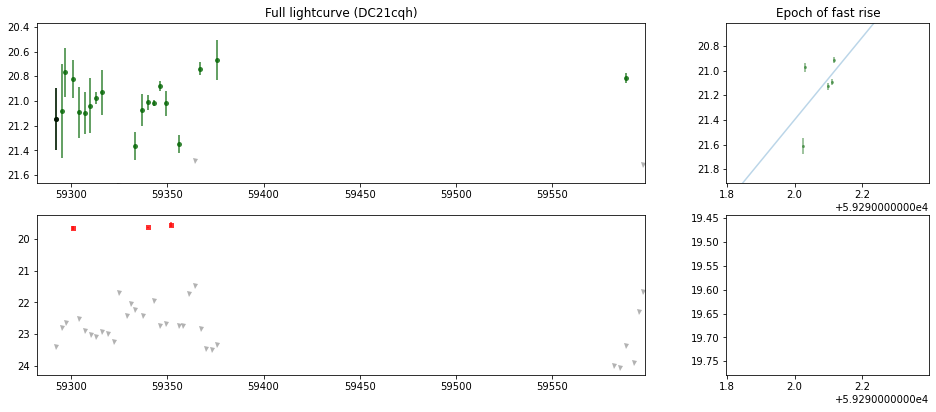

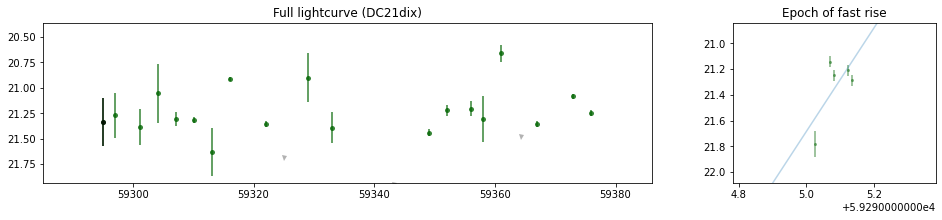

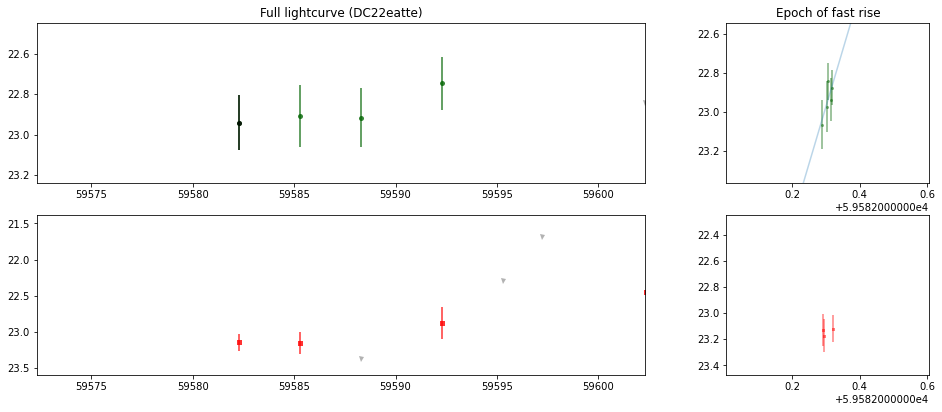

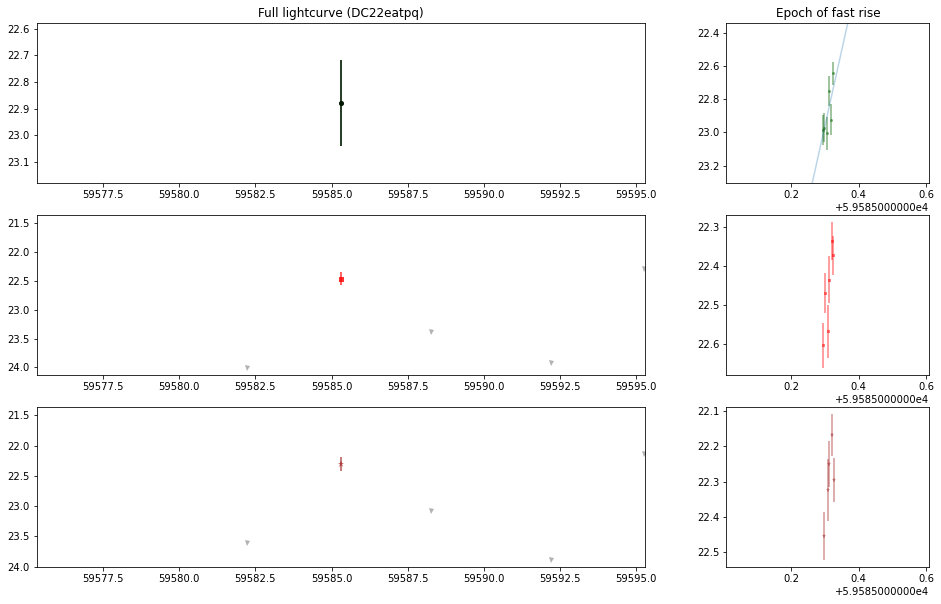

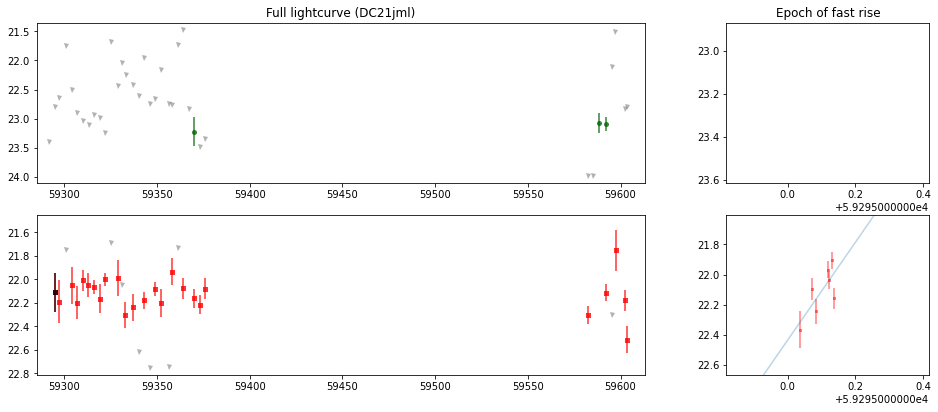

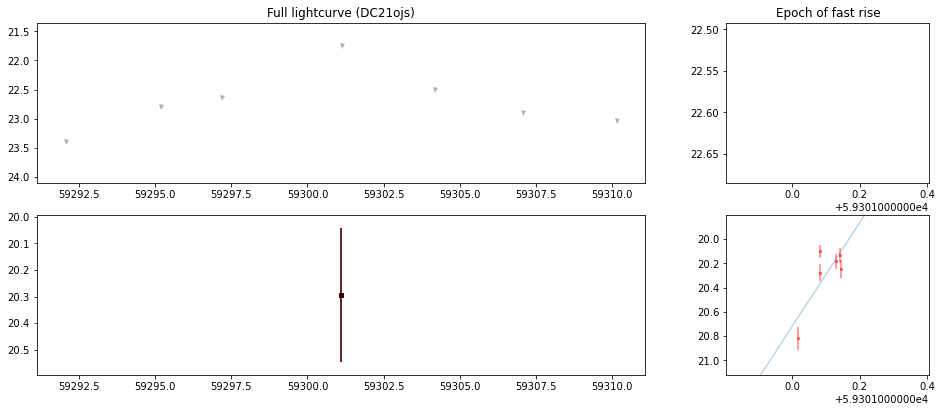

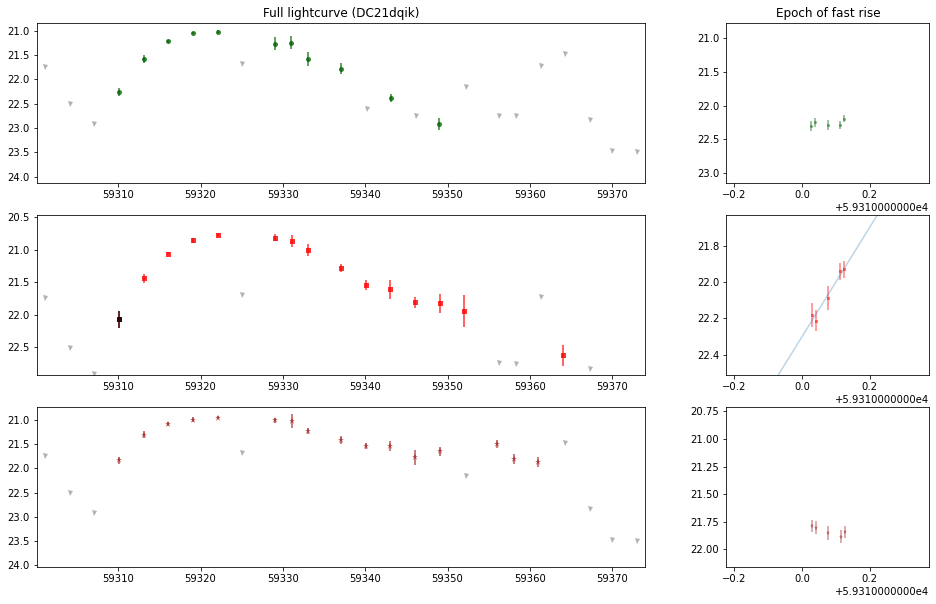

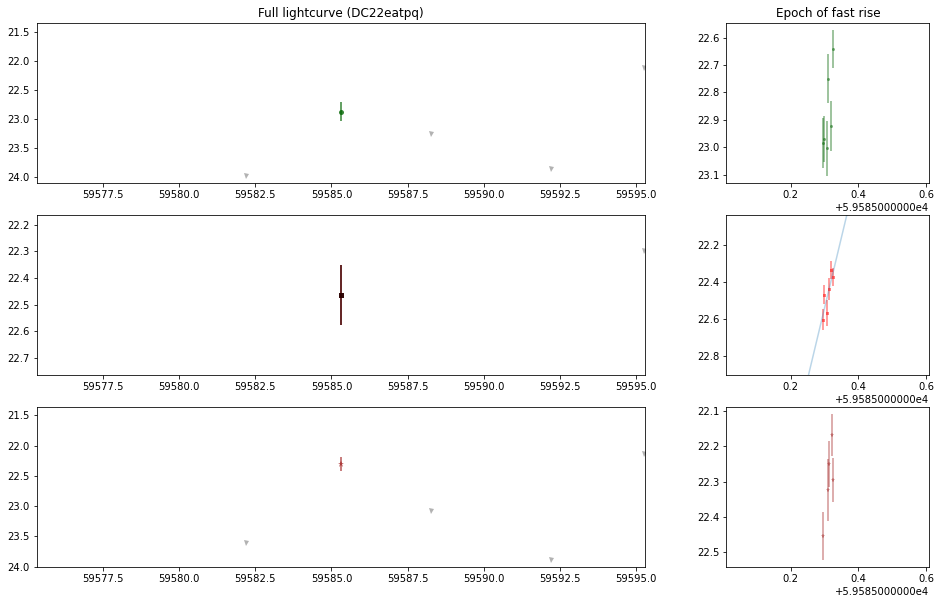

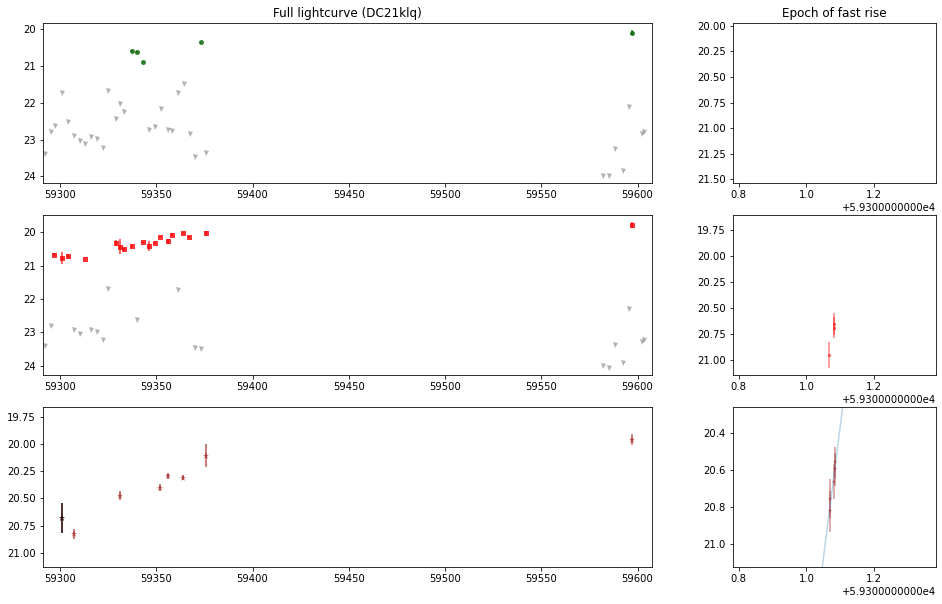

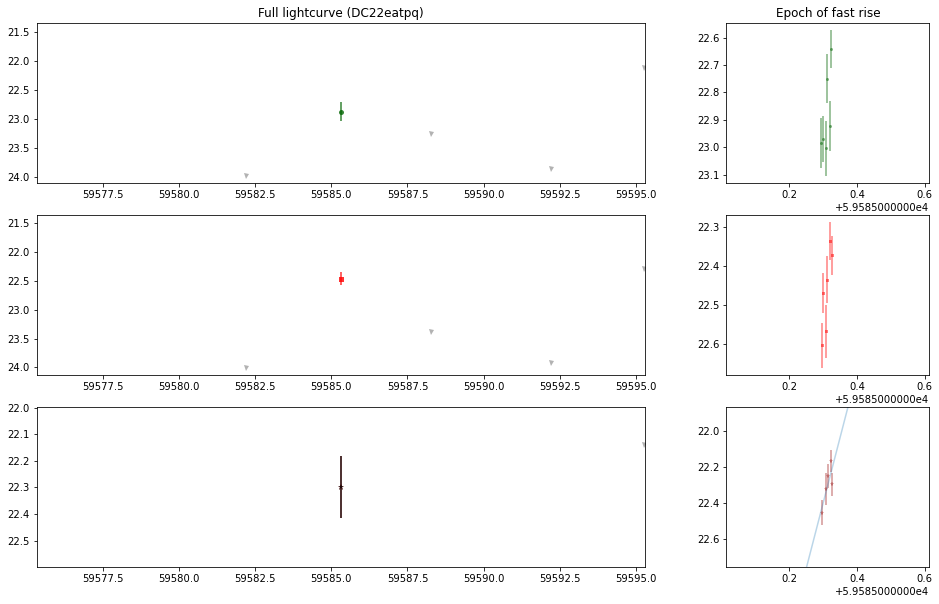

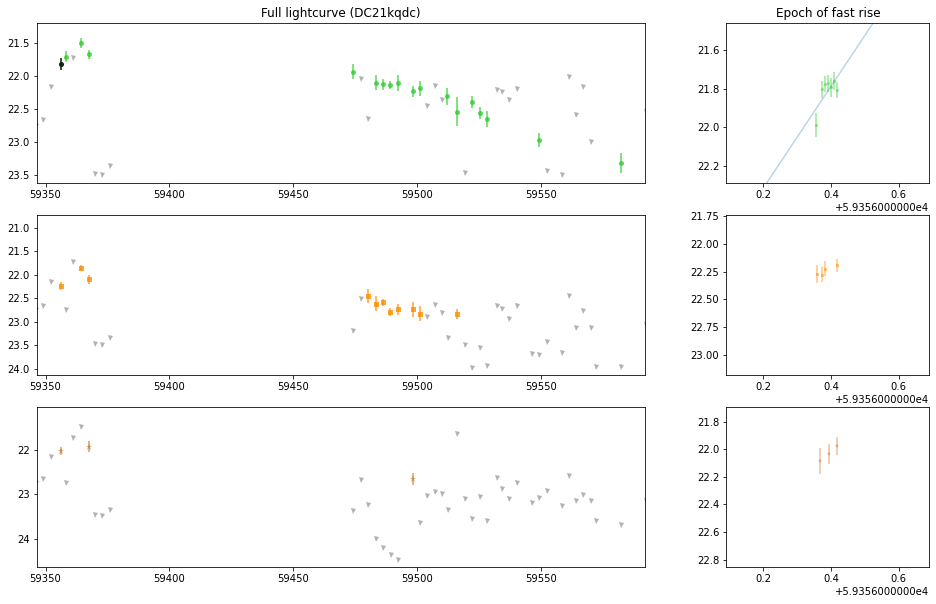

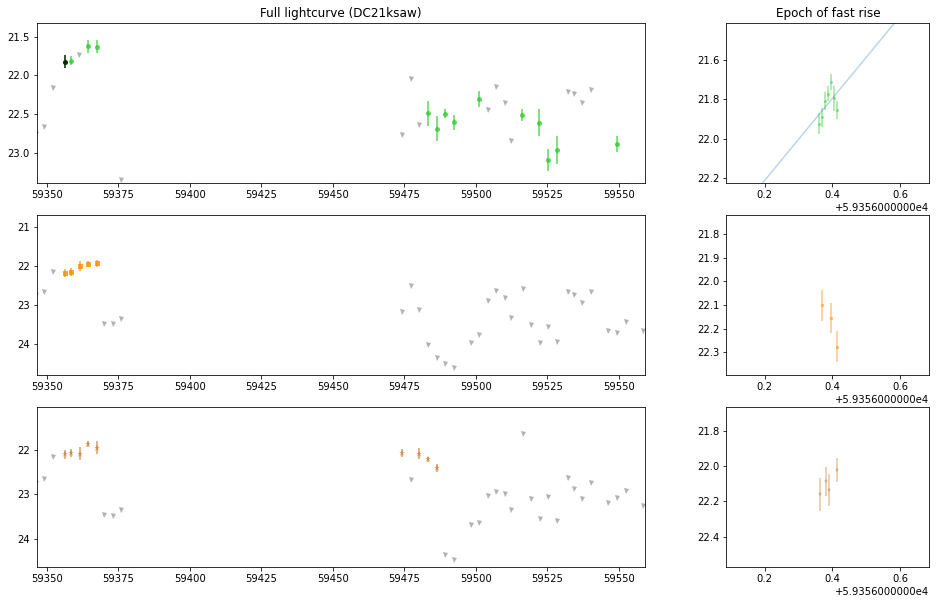

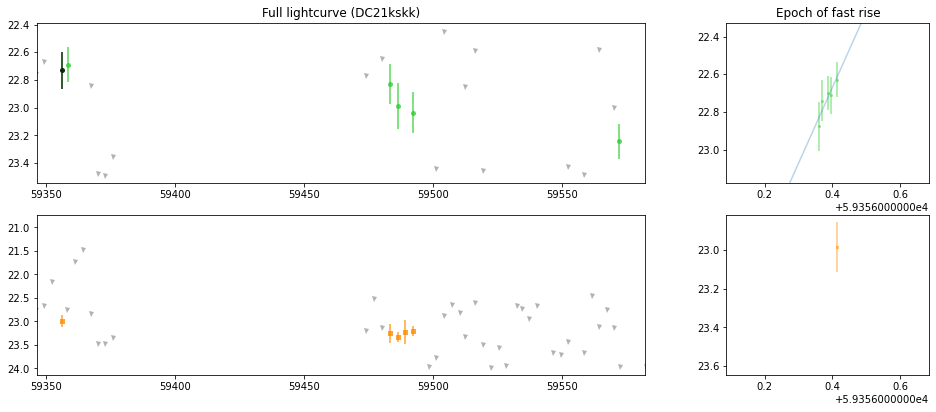

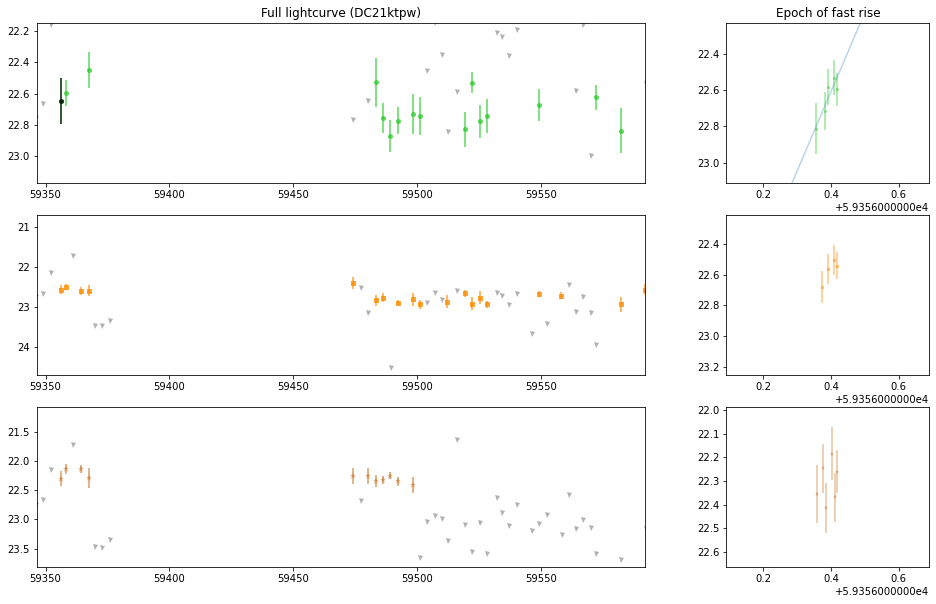

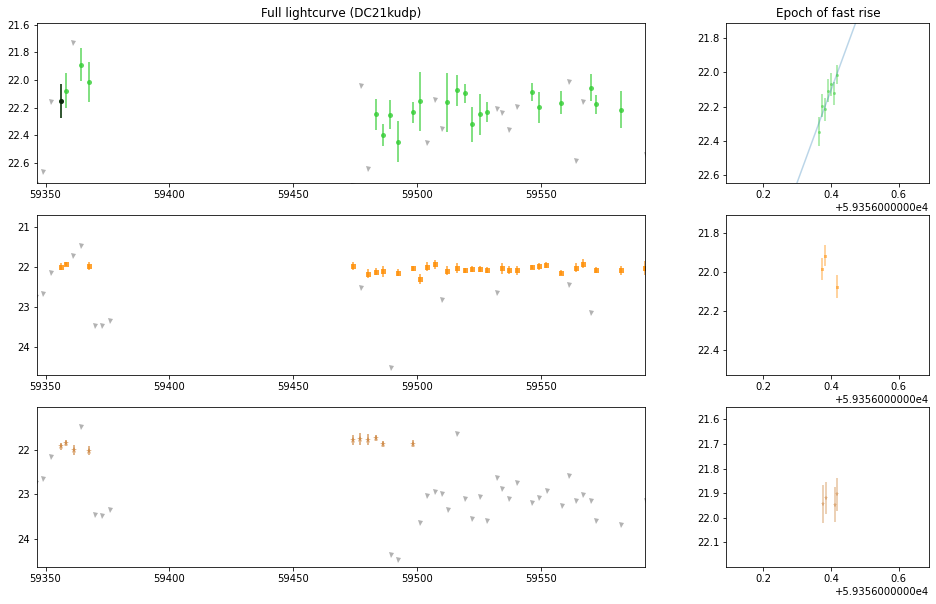

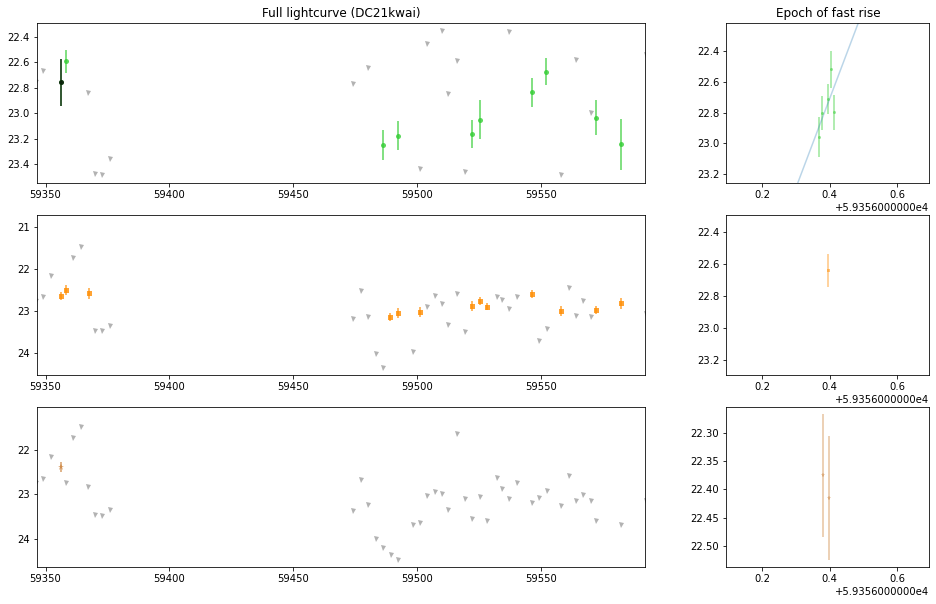

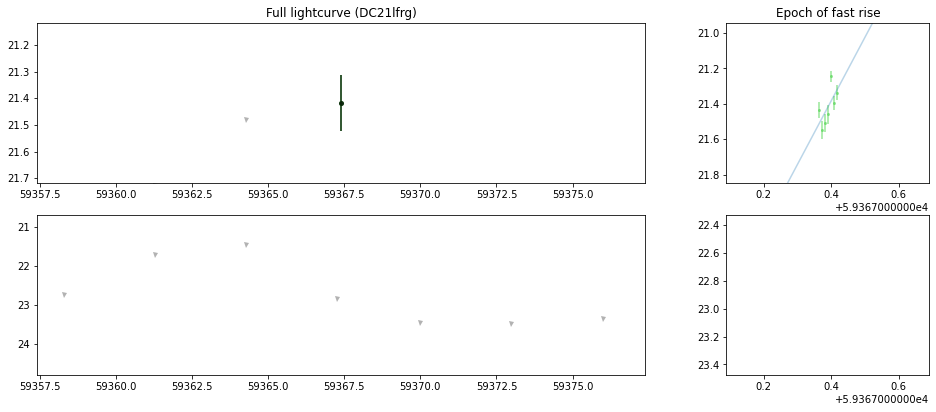

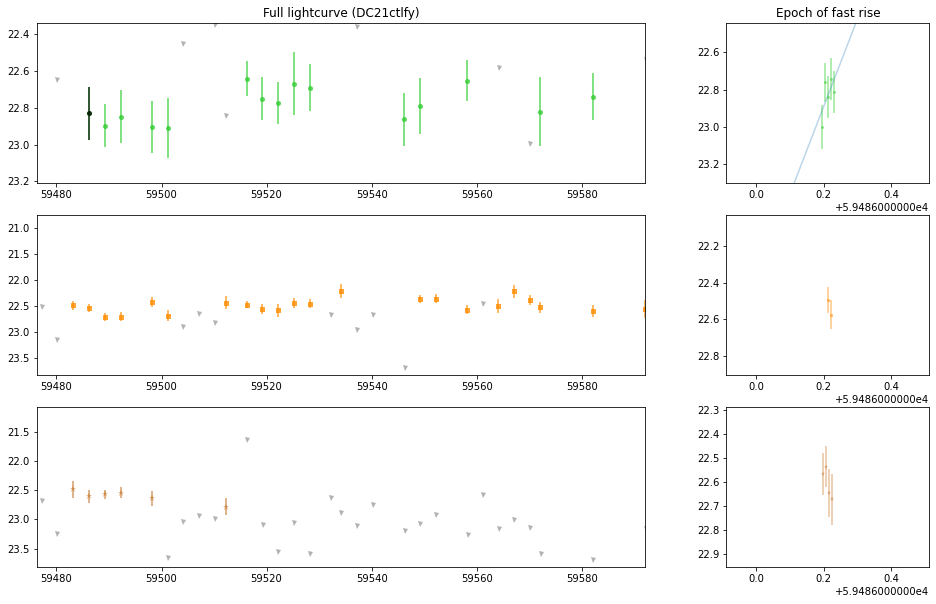

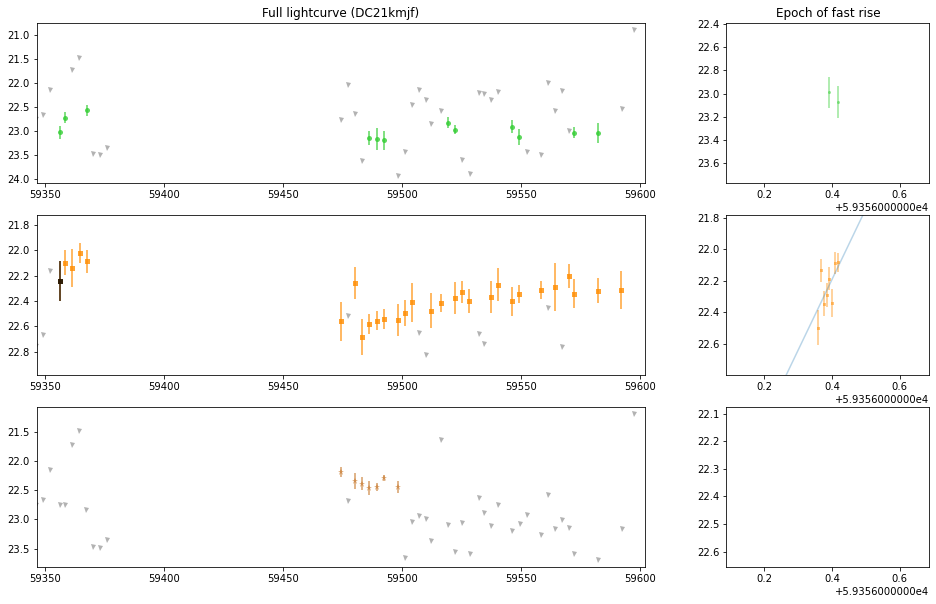

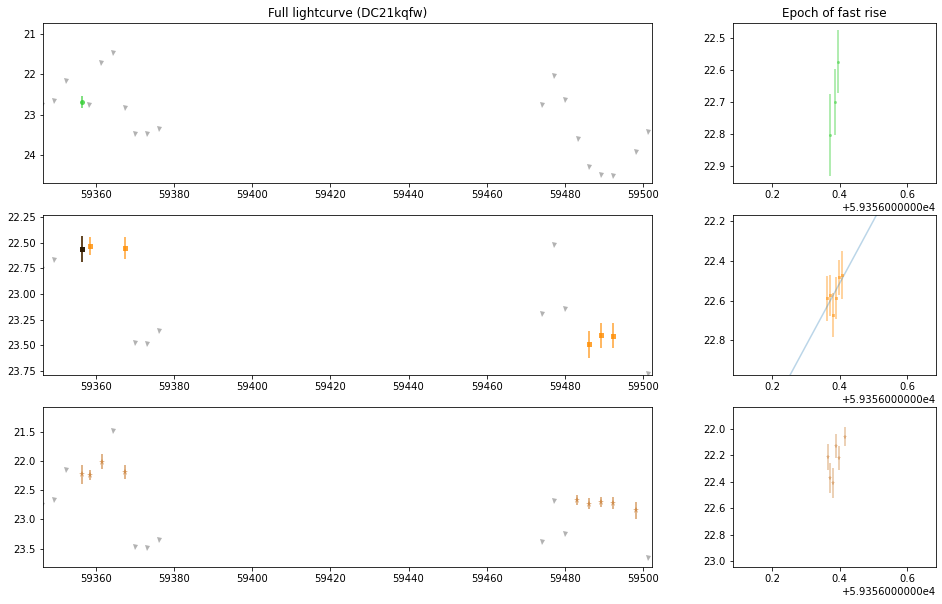

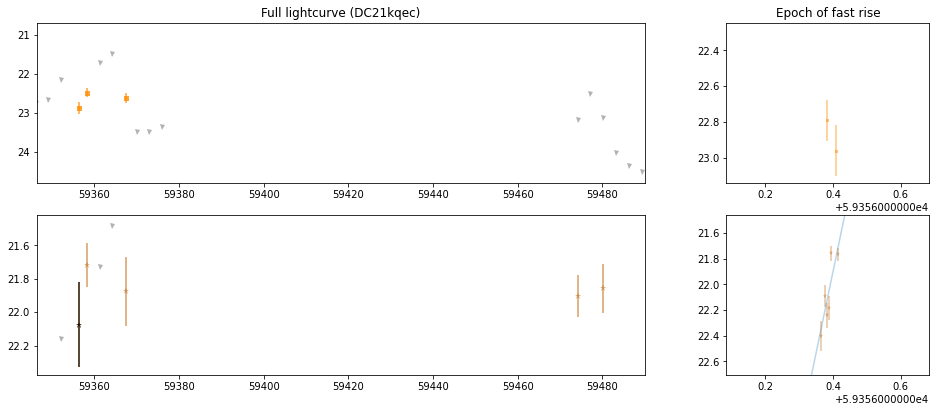

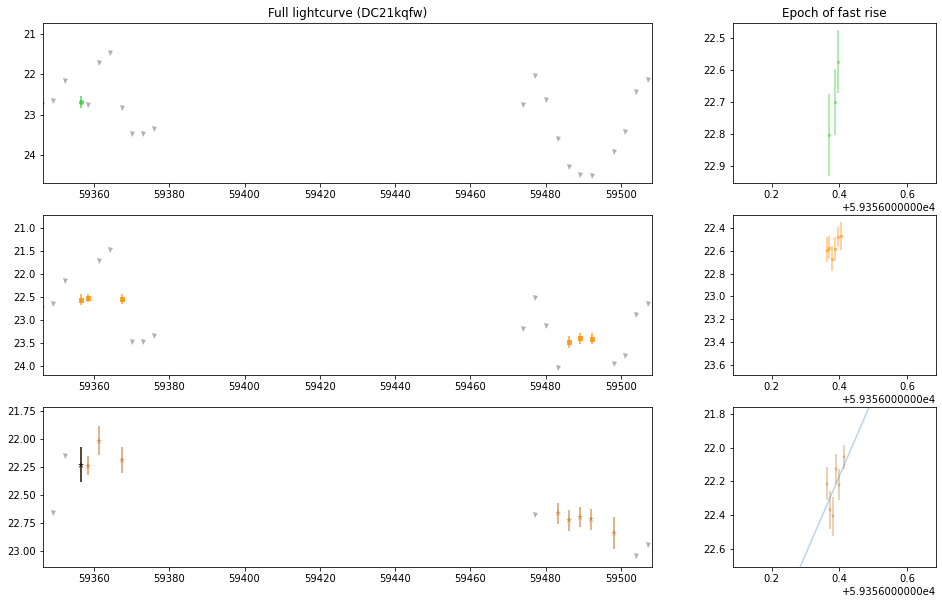

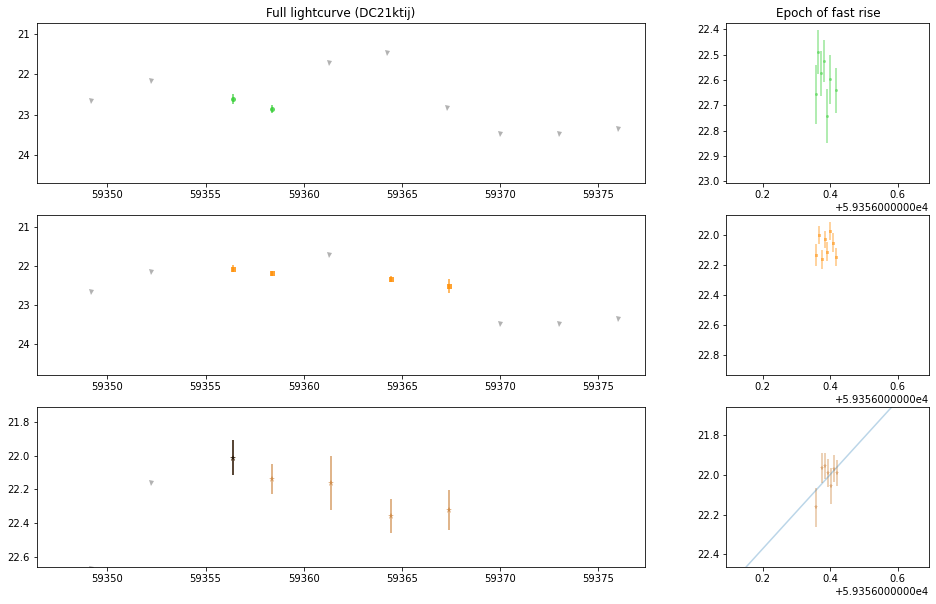

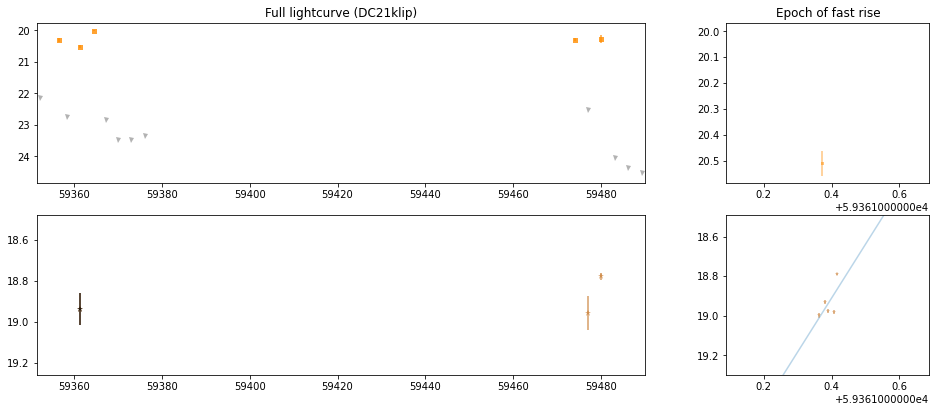

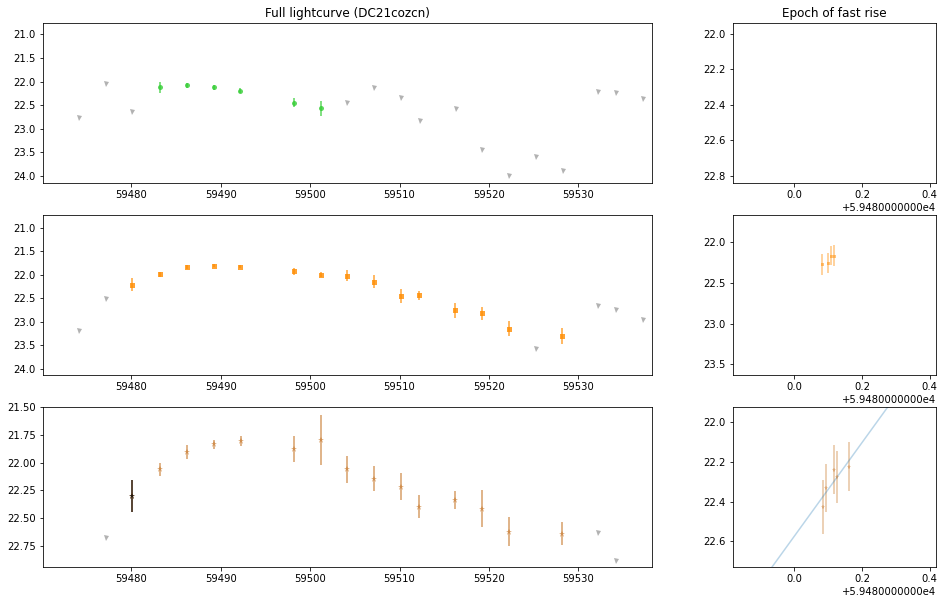

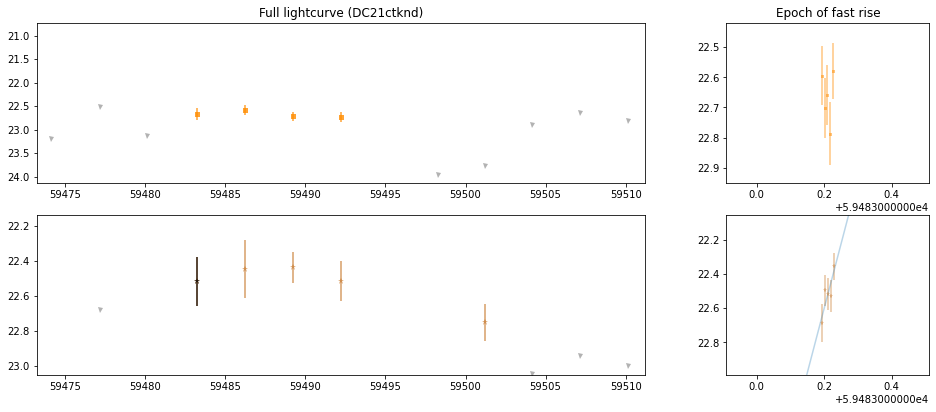

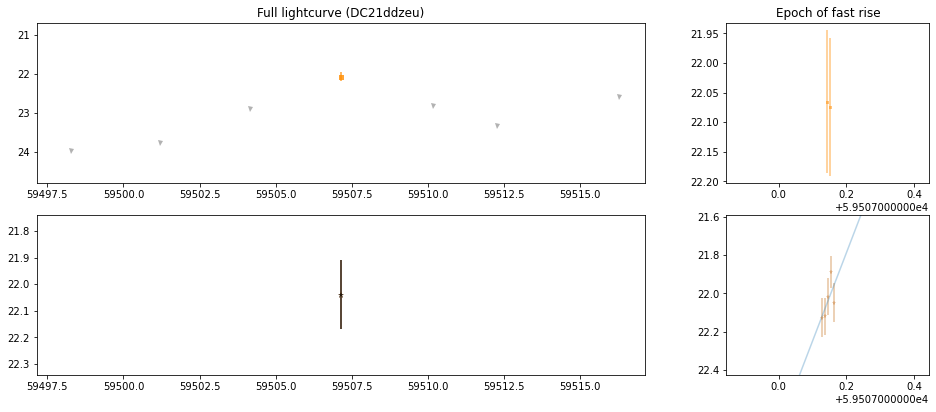

In [28]:
filts = ["g", "r", "i"]
all_fshapes = ['o','s','*']
all_fsizes  = [5, 5, 7]

for i in df[df["FirstNight"]==True].index:
# for i in df[df["Slope"]>0].index:
# for i in df[df["CandID"]=="DC21jai"].index:
# for i in range(len(fr[:30])):
    if df["Field"][i] == "COSMOS":
        all_fcolors = ["darkgreen","red","brown"]
        lmtmgs = clmtmgs
    elif df["Field"][i] == "ELAIS": 
        all_fcolors = ["limegreen","darkorange","peru"]
        lmtmgs = elmtmgs
    fig, ax = plt.subplots( 3, 2, figsize=(16,10), sharex='col', sharey=False, gridspec_kw={'width_ratios': [3, 1]} )
    n=0 # which row of the plot to put labels on
    for f in range(len(filts)):
        query = ('SELECT c.id, e.mjd, o.mag, o.magerr, o.ra FROM objects o '
                 'JOIN candidates c ON c.id=o.candidate_id '
                 'JOIN subtractions s ON s.id=o.subtraction_id '
                 'JOIN exposures e ON e.id=s.exposure_id '
                 'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
                 'WHERE c.id=%s '
                 'AND e.filter=%s '
                 'AND rbs.rb > 0.4')
        cursor.execute( query, ( fr[i], filts[f], ) )
        array = np.array( cursor.fetchall() ).transpose()
        array = rm_dupes(array)
        
        
        array2 = plotlc(fr[i], cursor, show_plot=False)
        ### At left, plot full lightcurve
        if len(array2) != 0:
            ax[f,0].errorbar( array2[0][f], array2[1][f], yerr=array2[2][f], fmt=all_fshapes[f], ms=all_fsizes[f], alpha=0.8, mew=0, color=all_fcolors[f] )

            msk = ~np.isin(odatesrd, np.round(array2[0][f]))
            ax[f,0].plot( odates[msk], lmtmgs[f][msk],'v', ms=5, alpha=0.6, mew=0, color='grey' )
            
        # ### at right, zoom in on one epoch
        if len(array) > 0:
            omjds  = array[1].astype(float)
            omags  = array[2].astype(float)
            omerrs = array[3].astype(float)
            ax[f,1].errorbar(omjds, omags, omerrs, fmt=all_fshapes[f], ms=all_fsizes[f]-2, alpha=0.5, mew=0, color=all_fcolors[f])
            ax[f,0].tick_params(labelbottom=True)
            ax[f,1].tick_params(labelbottom=True)
            
            if df["Filter"][i] == filts[f]:
                if len(array2[0][f]) != 0:
                    ax[f,0].set_xlim(array2[0][f][0]-10,array2[0][f][-1]+10)
                    ax[f,0].set_ylim(np.min(array2[1][f])-0.3,np.max(array2[1][f])+0.3)
                
                mjd = np.median(omjds[(omjds>frdates[i][0]) & (omjds<frdates[i][1])])
                mag = np.median(omags[(omjds>frdates[i][0]) & (omjds<frdates[i][1])])
                minmag = np.min(omags[(omjds>frdates[i][0]) & (omjds<frdates[i][1])])
                maxmag = np.max(omags[(omjds>frdates[i][0]) & (omjds<frdates[i][1])])
                
                xarr = np.linspace(mjd-0.3, mjd+0.3, 10)
                ax[f,1].plot(xarr, lin(xarr, df["Slope"][i], df["Intercept"][i]), alpha=0.3)
            
                ax[0,1].set_xlim(mjd-0.3, mjd+0.3)
                ax[1,1].set_xlim(mjd-0.3, mjd+0.3)
                ax[2,1].set_xlim(mjd-0.3, mjd+0.3)
                
                ax[f,1].set_ylim(minmag-0.3, maxmag+0.3)
                
                frmsk = np.where((array2[0][f] > mjd-0.5) & (array2[0][f] < mjd+0.5))[0][0]
                ax[f,0].errorbar( array2[0][f][frmsk], array2[1][f][frmsk], yerr=array2[2][f][frmsk], fmt=all_fshapes[f], ms=all_fsizes[f], alpha=0.8, mew=0, color="black" )
                # ax[f,0].vlines([mjd-0.3,mjd+0.3], mag-0.3, mag+0.3, alpha=0.3)
                # ax[f,0].hlines([mag-0.3,mag+0.3], mjd-0.3, mjd+0.3, alpha=0.3)
                
            ax[f,1].invert_yaxis()
            ax[f,0].invert_yaxis()
        else:
            fig.delaxes(ax[f,0])
            fig.delaxes(ax[f,1])
            if f==0:
                n=1
            
    ax[n,0].set_title("Full lightcurve ("+df["CandID"][i]+")")
    ax[n,1].set_title("Epoch of fast rise")
        
    plt.show()

In [24]:
### Helpful little snippet to make searching candidates in SDSS/TNS searching a bit easier
# engine="TNS"
# engine="SDSS"

# coordarr = np.empty( len( fr ), dtype=object )
# for i in range(len(fr)):
#     query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
#             'WHERE c.id=%s ')
#     cursor.execute( query, (fr[i], ) )
#     coordarr[i] = cursor.fetchall()[0]


# if engine == "SDSS":
#     for i in coordarr:
#         print(i[0])
#         print(str(i[1]))
#         print(str(i[2]))
# elif engine=="TNS":
#     for i in coordarr:
#         if i[2]>0:
#             print(i[0])
#             print(str(i[1]),"+"+str(i[2]))
#         else:
#             print(i[0])
#             print(str(i[1]),str(i[2]))